# BSPF Event Analysis - Fingerprintting

With pressure sensor parascientific and new sensor 

In [1]:
import os, sys
import obspy as obs
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy

sys.path.append("/home/andbro/andbro_python")

from andbro__store_as_pickle import __store_as_pickle
from andbro__savefig import __savefig

from functions.request_data import __request_data

In [2]:
sys.path.append("/home/andbro/Documents/ROMY/twistpy/TwistPy/")

from twistpy.utils import stransform
from twistpy.convenience import ricker
from twistpy.polarization import (
    TimeDomainAnalysis6C,
    PolarizationModel6C,
    SupportVectorMachine,
    EstimatorConfiguration,
)

In [3]:
if os.uname().nodename == 'lighthouse':
    root_path = '/home/andbro/'
    data_path = '/home/andbro/kilauea-data/'
    archive_path = '/home/andbro/freenas/'
    bay_path = '/home/andbro/bay200/'
elif os.uname().nodename == 'kilauea':
    root_path = '/home/brotzer/'
    data_path = '/import/kilauea-data/'
    archive_path = '/import/freenas-ffb-01-data/'
    bay_path = '/bay200/'
elif os.uname().nodename == 'lin-ffb-01':
    root_path = '/home/brotzer/'
    data_path = '/import/kilauea-data/'
    archive_path = '/import/freenas-ffb-01-data/'
    bay_path = '/bay200/'

## Configurations

In [4]:
config = {}

## BSPF coordinates
config['BSPF_lon'] = -116.455439
config['BSPF_lat'] = 33.610643

## output path for figures
config['path_to_figs'] = data_path+"BSPF/figures/M62_event/"


## Load Data

In [5]:
st0 = obs.read("./data/event62_6c.mseed")

In [6]:
st = st0.copy()

tbeg = st[0].stats.starttime
tend = st[0].stats.endtime

st.trim(tbeg, tend-20)

config['fmin'], config['fmax'] = 0.5, 2.0

st = st.detrend("simple")
st = st.taper(0.05)
st = st.filter("bandpass", freqmin=config['fmin'], freqmax=config['fmax'], corners=4, zerophase=True)

In [7]:
st0.resample(5.0, no_filter=False)

15 Trace(s) in Stream:
II.PFO.10.BHE  | 2022-11-22T16:40:09.994538Z - 2022-11-22T16:42:29.794538Z | 5.0 Hz, 700 samples
II.PFO.10.BHN  | 2022-11-22T16:40:09.994538Z - 2022-11-22T16:42:29.794538Z | 5.0 Hz, 700 samples
II.PFO.10.BHZ  | 2022-11-22T16:40:09.994538Z - 2022-11-22T16:42:29.794538Z | 5.0 Hz, 700 samples
II.RPFO.al.BJE | 2022-11-22T16:40:09.996685Z - 2022-11-22T16:42:29.796685Z | 5.0 Hz, 700 samples
II.RPFO.al.BJN | 2022-11-22T16:40:09.996685Z - 2022-11-22T16:42:29.796685Z | 5.0 Hz, 700 samples
II.RPFO.al.BJZ | 2022-11-22T16:40:09.996685Z - 2022-11-22T16:42:29.796685Z | 5.0 Hz, 700 samples
II.RPFO.in.BJE | 2022-11-22T16:40:09.996113Z - 2022-11-22T16:42:29.796113Z | 5.0 Hz, 700 samples
II.RPFO.in.BJN | 2022-11-22T16:40:09.996113Z - 2022-11-22T16:42:29.796113Z | 5.0 Hz, 700 samples
II.RPFO.in.BJZ | 2022-11-22T16:40:09.996113Z - 2022-11-22T16:42:29.796113Z | 5.0 Hz, 700 samples
II.RPFO.mi.BJE | 2022-11-22T16:40:09.996506Z - 2022-11-22T16:42:29.796506Z | 5.0 Hz, 700 samples
II.RPFO

## S-Transform

In [8]:
from functions.makeplotStream_cwt import __makeplotStream_cwt

In [9]:
# fig = __makeplotStream_cwt(st, config);

## 6C Fingerprinting

In [10]:
from scipy.signal import hilbert, convolve
from twistpy.convenience import ricker
from twistpy.polarization import *

In [11]:
acc = st.select(station="PFO*").copy()
rot = st.select(station="BSPF").copy()

scaling_velocity = 2000 ##2000

for tr in acc:
    tr.data /= scaling_velocity

### Time Domain

In [12]:
dt = rot[0].stats.delta

# !rm /home/andbro/Documents/ROMY/twistpy/TwistPy/twistpy/SVC_models/nearsurface.pkl

svm = SupportVectorMachine(name="nearsurface")

svm.train(
            wave_types=["R", "L", "SV", "Noise"],
            N=5000,
            scaling_velocity=scaling_velocity,
            vp=(500, 5000),
            vp_to_vs=(1.6, 2.2),
            vl=(500, 4000),
            vr=(500, 4000),
            phi=(0, 360),
            theta=(0, 90),
            xi=(-90, 90),
            free_surface=True,
            C=10,
            kernel="rbf",
            plot_confusion_matrix=True,
)

A trained model already exists with this name and is saved at '/home/andbro/Documents/ROMY/twistpy/TwistPy/twistpy/SVC_models/nearsurface.pkl'
Nothing will be done! Please delete the file above if you want to re-train this model.


In [13]:
twin = 2.5/config['fmin']
overlap = 0.75

analysis = TimeDomainAnalysis6C(
                                traN=acc.select(channel="*N")[0],
                                traE=acc.select(channel="*E")[0],
                                traZ=acc.select(channel="*Z")[0],
                                rotN=rot.select(channel="*N")[0],
                                rotE=rot.select(channel="*E")[0],
                                rotZ=rot.select(channel="*Z")[0],
                                window={"window_length_seconds": twin , "overlap": overlap},
                                scaling_velocity=scaling_velocity,
                                timeaxis="rel",
)

analysis.classify(svm=svm, eigenvector_to_classify=0)

classification = analysis.classification["0"]

t_windows = (analysis.t_windows)  # Positions of the sliding time windows where the classification was performed

Computing covariance matrices...
Covariance matrices computed!
Performing eigen-decomposition of covariance matrices...
Eigenvectors and eigenvalues have been computed!
Wave type classification in progress...
Wave types have been classified!


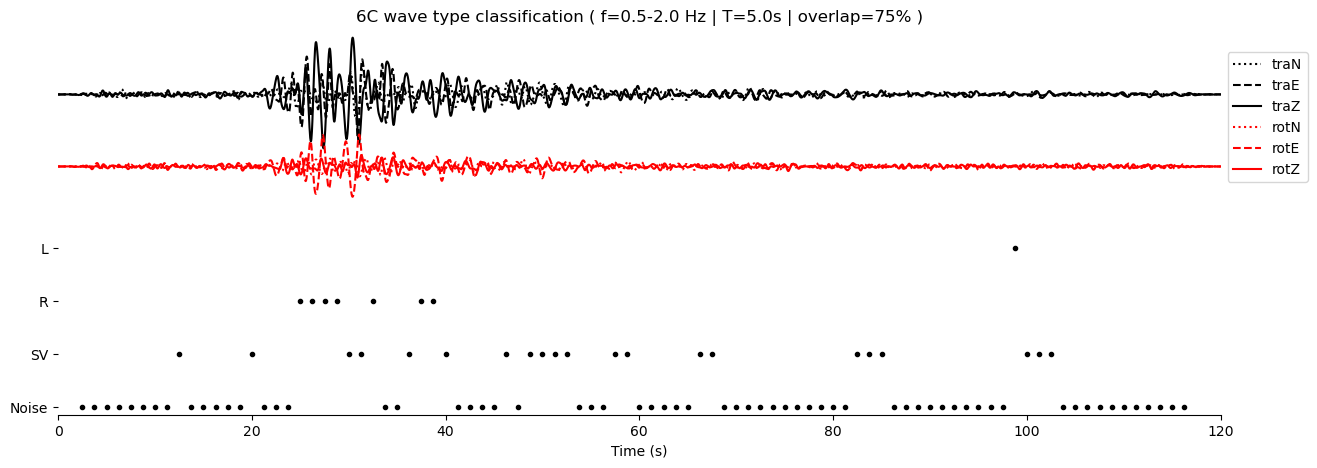

In [14]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=False, figsize=(15, 5))

t = acc.select(channel="*N")[0].times()

ax1.plot(t, 1e-6+acc.select(channel="*N")[0].data, "k:", label="traN")
ax1.plot(t, 1e-6+acc.select(channel="*E")[0].data, "k--", label="traE")
ax1.plot(t, 1e-6+acc.select(channel="*Z")[0].data, "k", label="traZ")
ax1.plot(t, -1e-6+rot.select(channel="*N")[0].data, "r:", label="rotN")
ax1.plot(t, -1e-6+rot.select(channel="*E")[0].data, "r--", label="rotE")
ax1.plot(t, -1e-6+rot.select(channel="*Z")[0].data, "r", label="rotZ")
ax1.legend(loc="center left", bbox_to_anchor=(1, 0.5))
# ax1.set_title("")
ax1.set_yticklabels([])
ax1.set_title(f"6C wave type classification ( f={config['fmin']}-{config['fmax']} Hz | T={twin}s | overlap={int(overlap*100)}% )")

ax2.plot(t_windows, classification, "k.")
ax2.set_xlabel("Time (s)")
# ax2.set_ylabel("Classification label")

ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['left'].set_visible(False)
ax1.spines['bottom'].set_visible(False)
ax1.get_yaxis().set_ticks([])
ax1.get_xaxis().set_ticks([])

ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['left'].set_visible(False)

ax1.set_xlim(min(t), max(t))
ax2.set_xlim(min(t), max(t))


plt.show();


# fig.savefig(config['path_to_figs']+f"BSPF_M62_fingerprinting_timedomain.png", format="png", dpi=150, bbox_inches='tight');


### Frequency Domain

In [ ]:
svm = SupportVectorMachine(name="nearsurface")

analysis_tf = TimeFrequencyAnalysis6C(
                                        traN=acc.select(channel="*N")[0],
                                        traE=acc.select(channel="*E")[0],
                                        traZ=acc.select(channel="*Z")[0],
                                        rotN=rot.select(channel="*N")[0],
                                        rotE=rot.select(channel="*E")[0],
                                        rotZ=rot.select(channel="*Z")[0],
                                        window={"number_of_periods": twin, "frequency_extent": 1},
                                        timeaxis="rel",
                                        scaling_velocity=scaling_velocity,
)

analysis_tf.classify(svm=svm, eigenvector_to_classify=0)

classification_tf = analysis_tf.classification["0"]


Computing covariance matrices...


In [ ]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(15, 5))

t = acc.select(channel="*N")[0].times()

ax1.plot(t, acc.select(channel="*N")[0].data, "k:", label="traN")
ax1.plot(t, acc.select(channel="*E")[0].data, "k--", label="traE")
ax1.plot(t, acc.select(channel="*Z")[0].data, "k", label="traZ")
ax1.plot(t, rot.select(channel="*N")[0].data, "r:", label="rotN")
ax1.plot(t, rot.select(channel="*E")[0].data, "r--", label="rotE")
ax1.plot(t, rot.select(channel="*Z")[0].data, "r", label="rotZ")
ax1.legend(loc="center left", bbox_to_anchor=(1, 0.5))
ax1.set_title("Input signal")

ax2.set_title("Wave type classification")
ax2.set_xlabel("Time (s)")
ax2.set_ylabel("Classification label")
analysis_tf.plot_classification(ax2)

pos0 = ax1.get_position()
pos = ax2.get_position()
ax1.set_position([pos0.x0, pos0.y0, pos.width, pos.height])


plt.show();

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=False, figsize=(15, 5))

lw = 1.5

t = acc.select(channel="*N")[0].times()

ax1.plot(t, 1e-6+acc.select(channel="*N")[0].data, "k:", label="traN", lw=lw)
ax1.plot(t, 1e-6+acc.select(channel="*E")[0].data, "k--", label="traE", lw=lw)
ax1.plot(t, 1e-6+acc.select(channel="*Z")[0].data, "k", label="traZ", lw=lw)
ax1.plot(t, -1e-6+rot.select(channel="*N")[0].data, "r:", label="rotN", lw=lw)
ax1.plot(t, -1e-6+rot.select(channel="*E")[0].data, "r--", label="rotE", lw=lw)
ax1.plot(t, -1e-6+rot.select(channel="*Z")[0].data, "r", label="rotZ", lw=lw)
ax1.legend(loc="center left", bbox_to_anchor=(1, 0.5))
ax1.set_yticklabels([])
ax1.set_title(f"6C wave type classification ( f={config['fmin']}-{config['fmax']} Hz | T={twin}s | overlap={int(overlap*100)}% )")


pos1 = ax1.get_position()
analysis_tf.plot_classification(ax2, clip=0.05)
pos0 = ax2.get_position()

ax1.set_position([pos1.x0, pos1.y0, pos0.width, pos0.height])


ax3.plot(t_windows, classification, "k.")
pos3 = ax3.get_position()
ax3.set_position([pos3.x0, pos3.y0, pos0.width, pos0.height])


ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['left'].set_visible(False)
ax1.spines['bottom'].set_visible(False)
ax1.get_yaxis().set_ticks([])
ax1.get_xaxis().set_ticks([])

ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['left'].set_visible(False)
ax2.spines['bottom'].set_visible(False)
ax2.get_yaxis().set_ticks([])
ax2.get_xaxis().set_ticks([])
ax2.set_ylim(0, 5)
ax2.set_xlabel("")

ax3.spines['top'].set_visible(False)
ax3.spines['right'].set_visible(False)
ax3.spines['left'].set_visible(False)
ax3.set_ylim(-1, 4)
ax3.set_xlabel("Time (s)")

ax1.set_xlim(min(t)-1, max(t)+1)
ax2.set_xlim(min(t)-1, max(t)+1)
ax3.set_xlim(min(t)-1, max(t)+1)


plt.show();


fig.savefig(config['path_to_figs']+f"BSPF_M62_fingerprinting.png", format="png", dpi=150, bbox_inches='tight');


## 6C Polarization

In [ ]:
# !rm /home/andbro/Documents/ROMY/twistpy/TwistPy/twistpy/SVC_models/test.pkl

# svm = SupportVectorMachine(name="test")


# svm.train(

#         wave_types=["R", "P", "SV", "L", "Noise"],
#         N=5000,
#         scaling_velocity=scaling_velocity,
#         vp=(100, 5000),
#         vp_to_vs=(1.7, 2.4),
#         vl=(100, 5000),
#         vr=(100, 5000),
#         phi=(0, 360),
#         theta=(0, 90),
#         xi=(-90, 90),
#         free_surface=True,
#         C=1,
#         kernel="rbf",
#         plot_confusion_matrix=False,

# )

In [ ]:
analysis = TimeDomainAnalysis6C(
                                traN=acc.select(channel="*N")[0],
                                traE=acc.select(channel="*E")[0],
                                traZ=acc.select(channel="*Z")[0],
                                rotN=rot.select(channel="*N")[0],
                                rotE=rot.select(channel="*E")[0],
                                rotZ=rot.select(channel="*Z")[0],
                                window={"window_length_seconds":  2/config['fmin'], "overlap": 0.75},
                                scaling_velocity=scaling_velocity,
                                timeaxis="rel",
)


In [ ]:
analysis.classify(svm=svm, eigenvector_to_classify=0)

classification = analysis.classification["0"]

t_windows = (analysis.t_windows)  # Positions of the sliding time windows where the classification was performed

#  Wave parameter estimation

est = EstimatorConfiguration(
                            wave_types=["L", "R"],
                            method="ML",
                            scaling_velocity=scaling_velocity,
                            use_ml_classification=True,
                            svm=svm,
)

analysis.polarization_analysis(estimator_configuration=est)

analysis.plot(estimator_configuration=est, dop_clip=0.0)
